<h1><center><font size="6">TMDB Box Office Prediction</font></center></h1>


https://www.kaggle.com/c/tmdb-box-office-prediction

https://www.kaggle.com/zero92/tmdb-prediction


<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>
- <a href='#4'>Data exploration</a>   
 - <a href='#41'>Check the data</a>   
  - <a href='#42'>Clean Data</a>   
- <a href='#3'>External Data</a>    
- <a href='#5'>EDA</a>     
- <a href='#6'>Feature engineering</a>
- <a href='#7'>Model</a>
- <a href='#8'>Submission</a>  

# <a id='1'>Introduction</a>  

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

# <a id='2'>Prepare for data analysis</a>  


## Load packages

In [1]:
import numpy as np 
import pandas as pd 


# DRAGONS
import xgboost as xgb
# import lightgbm as lgb
# import catboost as cat


# plots
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import ast
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import os
# print(os.listdir("../input"))




random_seed = 2019

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

If  is the predicted value of the -th sample, and  is the corresponding true value, then the mean squared error (MSE) estimated over  is defined as

In [2]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Load data  

In [4]:
#%%time
train = pd.read_csv('KData/train.csv')
test = pd.read_csv('KData/test.csv')
train.index = train['id']
test.index = test['id']

# <a id='4'>Data exploration</a>  

## <a id='41'>Check the data</a>  

Let's check the train and test set.

In [5]:
print("Dimension of train : " + str(train.shape) + " || Dimension of test : " + str(test.shape))

Dimension of train : (3000, 23) || Dimension of test : (4398, 22)


In [7]:
train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [8]:
print("Types columns : \n" + str(train.dtypes))

Types columns : 
id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object


In [12]:
print("Count NA Train for the variable budget : \n" + str(train[train.budget == 0].shape[0]) + "\n")
print("Count NA Test for the variable budget : \n" + str(test[test.budget == 0].shape[0]) + "\n")
print("Count NA Train per column : \n" + str(train.isna().sum()))


Count NA Train for the variable budget : 
812

Count NA Test for the variable budget : 
1211

Count NA Train per column : 
id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64


## <a id='42'>Clean Data</a>    

In [13]:
train.loc[train['id'] == 16,'revenue'] = 192864         
train.loc[train['id'] == 90,'budget'] = 30000000                  
train.loc[train['id'] == 118,'budget'] = 60000000       
train.loc[train['id'] == 149,'budget'] = 18000000       
train.loc[train['id'] == 313,'revenue'] = 12000000       
train.loc[train['id'] == 451,'revenue'] = 12000000      
train.loc[train['id'] == 464,'budget'] = 20000000       
train.loc[train['id'] == 470,'budget'] = 13000000       
train.loc[train['id'] == 513,'budget'] = 930000         
train.loc[train['id'] == 797,'budget'] = 8000000        
train.loc[train['id'] == 819,'budget'] = 90000000       
train.loc[train['id'] == 850,'budget'] = 90000000       
train.loc[train['id'] == 1007,'budget'] = 2              
train.loc[train['id'] == 1112,'budget'] = 7500000       
train.loc[train['id'] == 1131,'budget'] = 4300000        
train.loc[train['id'] == 1359,'budget'] = 10000000       
train.loc[train['id'] == 1542,'budget'] = 1             
train.loc[train['id'] == 1570,'budget'] = 15800000       
train.loc[train['id'] == 1571,'budget'] = 4000000        
train.loc[train['id'] == 1714,'budget'] = 46000000       
train.loc[train['id'] == 1721,'budget'] = 17500000       
train.loc[train['id'] == 1865,'revenue'] = 25000000      
train.loc[train['id'] == 1885,'budget'] = 12             
train.loc[train['id'] == 2091,'budget'] = 10             
train.loc[train['id'] == 2268,'budget'] = 17500000       
train.loc[train['id'] == 2491,'budget'] = 6              
train.loc[train['id'] == 2602,'budget'] = 31000000       
train.loc[train['id'] == 2612,'budget'] = 15000000       
train.loc[train['id'] == 2696,'budget'] = 10000000      
train.loc[train['id'] == 2801,'budget'] = 10000000       
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9              
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

In [14]:
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

In [15]:
train

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
6,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
7,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
8,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
9,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.90242

# <a id='3'>External Data</a> 

Contains dates per country

In [17]:
release_dates = pd.read_csv('KData/release_dates_per_country.csv')
release_dates['id'] = range(1,7399)
release_dates.drop(['original_title','title'],axis = 1,inplace = True)
release_dates.index = release_dates['id']
train.drop('id',axis = 1,inplace = True)
test.drop('id',axis = 1,inplace = True)
release_dates.drop('id',axis = 1,inplace = True)
train = pd.merge(train, release_dates, how='left', on=['id'])
test = pd.merge(test, release_dates, how='left', on=['id'])

Contains the variables totalVotes and vote_average

In [ ]:
#WARNING:
# The originator must have gone to TMDB himself and grabbed this data. No access to this file is granted on kaggle.
# so will remove the columns from model as needed.
# vote = pd.read_csv('../input/just-for-fun/just_for_fun.csv')[["vote_count","vote_average"]]
# vote['id'] = range(1,7399)
# vote.index = vote['id']
# vote.drop('id',axis = 1,inplace = True)
# train = pd.merge(train, vote, how='left', on=['id'])
# test = pd.merge(test, vote, how='left', on=['id'])

**The data below comes from the kernel EDA, Feature Engineering, LGB+XGB+CAT of Kamal Chhirang**

In [48]:
trainAdditionalFeatures = pd.read_csv('KData/TrainAdditionalFeatures.csv')[['imdb_id','popularity2','rating']]
testAdditionalFeatures = pd.read_csv('KData/TestAdditionalFeatures.csv')[['imdb_id','popularity2','rating']]

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'], right_index  = True)
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'], right_index  = True)

# <a id='5'>EDA</a>  

Text(0.5, 1.0, 'Link between revenue and budget')

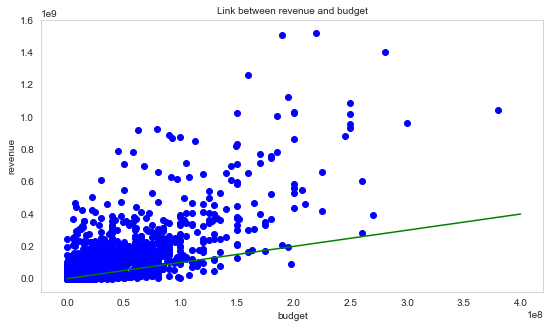

In [49]:
x1 = np.array(train["budget"])
y1 = np.array(train["revenue"])

fig = plt.figure(1, figsize=(9, 5))


plt.plot([0,400000000],[0,400000000],c="green")  # line showing plot x = 400million, y = 400 million
plt.scatter(x1, y1, c=['blue'],marker='o')
plt.grid()
plt.xlabel("budget", fontsize=10)  
plt.ylabel("revenue", fontsize=10)
plt.title("Link between revenue and budget", fontsize=10)

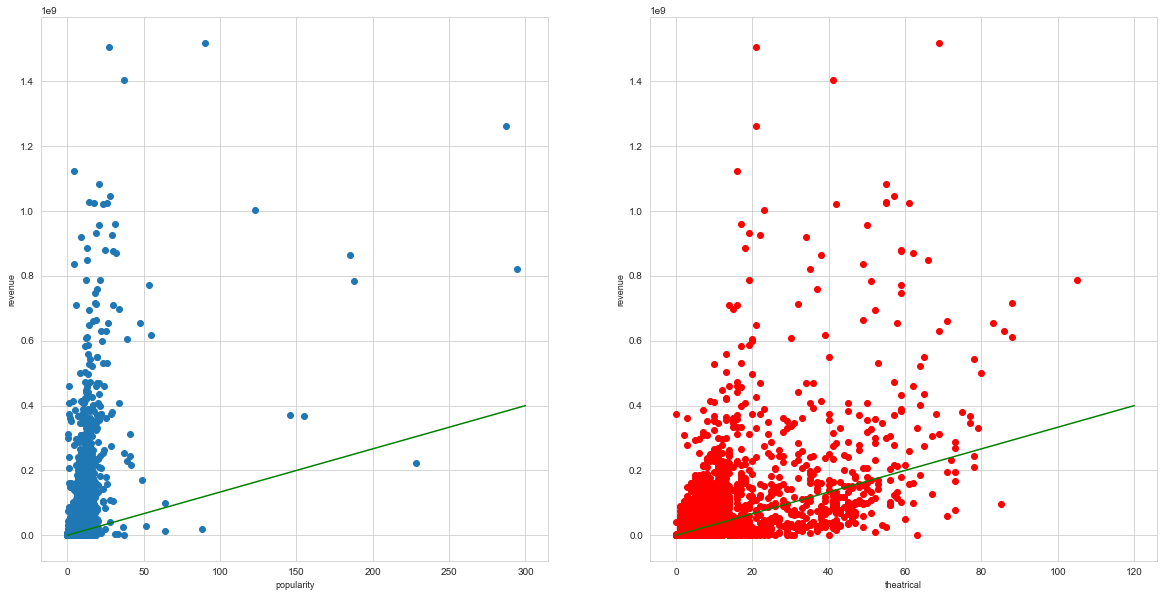

In [51]:
sns.set_style('whitegrid') #The whitegrid theme is similar, but it is better suited to plots 
#sns.set_style('darkgrid') #   with heavy data elements  

fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.subplot(1,2,1)
plt.plot([0,300],[0,400000000],c="green")
plt.scatter(train["popularity"], train["revenue"], marker='o')
plt.xlabel("popularity", fontsize=9)
plt.ylabel("revenue", fontsize=9)
plt.subplot(1,2,2)
plt.plot([0,120],[0,400000000],c="green")
plt.scatter(train["theatrical"], train["revenue"], marker='o',color = 'red')
plt.xlabel("theatrical", fontsize=9)
plt.ylabel("revenue", fontsize=9)
plt.show()

It is clear from the graph below that revenue depends a lot on budget and total_vote

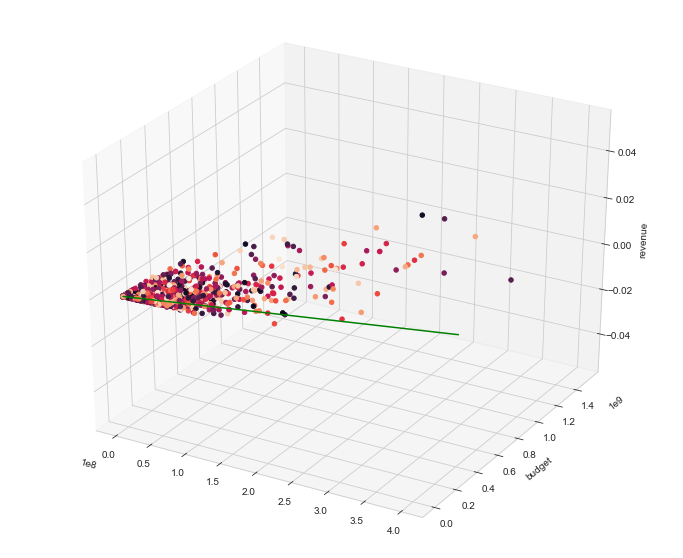

In [52]:
fig, ax = plt.subplots(1,2,figsize=(12,10))
plt.subplot(1,2,1)
ax = plt.subplot(projection='3d')
colors = np.random.rand(len(train))

#xs = np.array(train['vote_count'])
ys = np.array(train['budget'])
zs = np.array(train['revenue'])
#ax.scatter(xs,ys, zs, c= colors,marker='o', alpha=1)
#plt.plot([0,17500],[0,400000000],[0,400000000],c="green")
ys = np.array(train['budget'])
zs = np.array(train['revenue'])
plt.plot([0,400000000],[0,400000000],c="green")
ax.scatter(ys, zs, c= colors,marker='o', alpha=1)

#ax.set_xlabel('vote_count')
ax.set_ylabel('budget')
ax.set_zlabel('revenue')

plt.show()

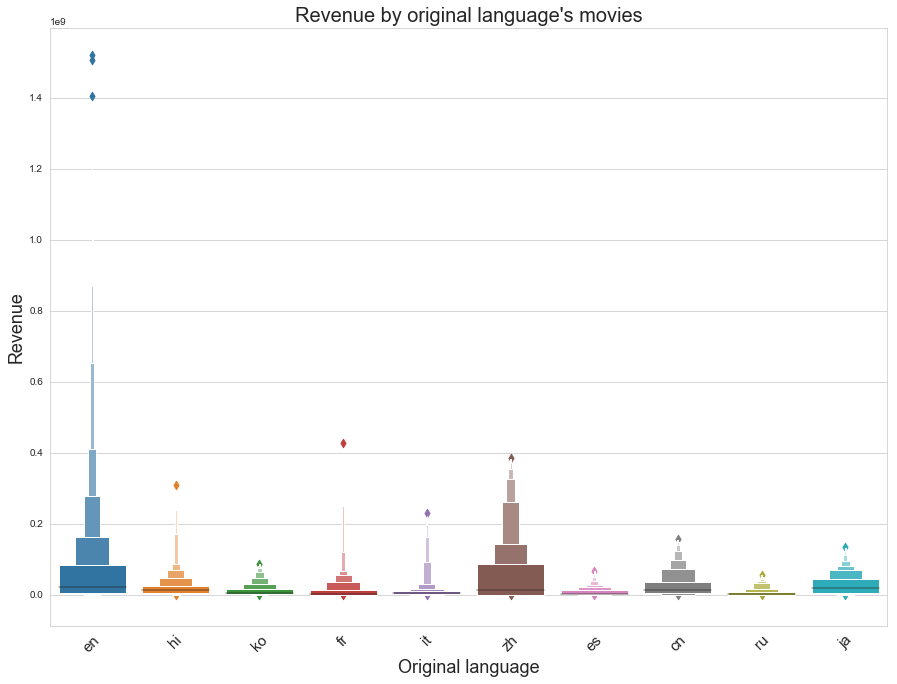

In [36]:
plt.figure(figsize=(15,11)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='original_language', y='revenue', 
                   data=train[(train['original_language'].isin((train['original_language'].value_counts()[:10].index.values)))])
g1.set_title("Revenue by original language's movies", fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45, fontsize=15) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Original language', fontsize=18) # Xlabel
g1.set_ylabel('Revenue', fontsize=18) #Ylabel

plt.show()

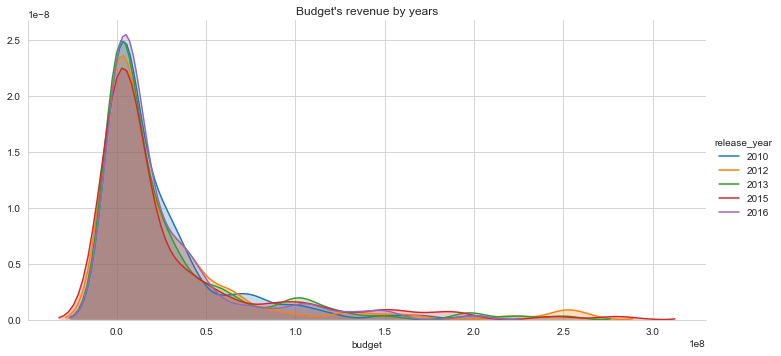

In [53]:
(sns.FacetGrid(train[(train['release_year']\
                        .isin(train['release_year']\
                              .value_counts()[:5].index.values))],
               hue='release_year', height=5, aspect=2)
  .map(sns.kdeplot, 'budget', shade=True)
 .add_legend()
)
plt.title("Budget's revenue by years")
plt.show()


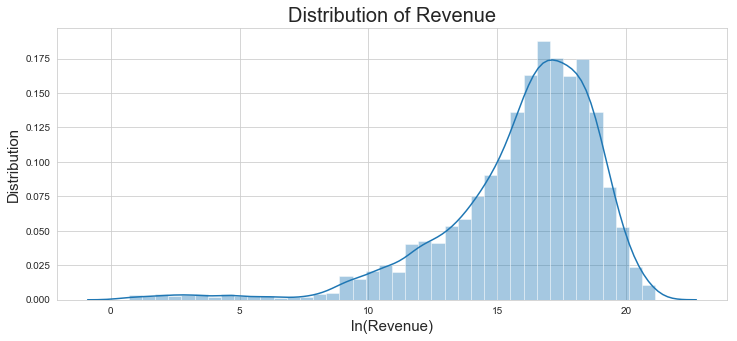

In [58]:
plt.figure(figsize=(12,5))

# Subplot allow us to plot more than one 
# in this case, will be create a subplot grid of 2 x 1

# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot(np.log1p(train['revenue']), bins=40, kde=True)
#ax = sns.distplot(train['revenue'], bins=40, kde=True)
ax.set_xlabel('ln(Revenue)', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribution', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribution of Revenue", fontsize=20); #setting the title and size of font

### Correlation Matrix

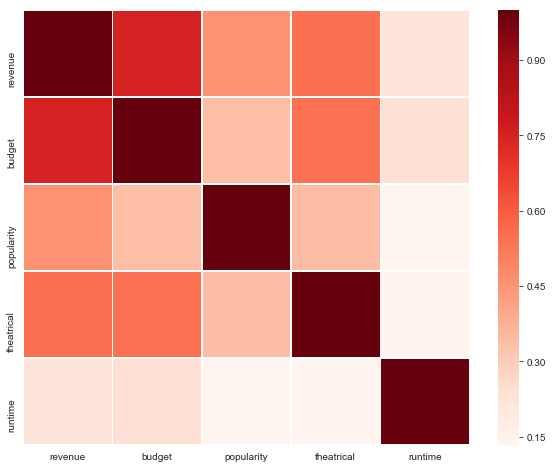

In [59]:
col = ['revenue','budget','popularity','theatrical','runtime']

plt.subplots(figsize=(10, 8))

corr = train[col].corr()

sns.heatmap(corr, xticklabels=col,yticklabels=col, linewidths=.5, cmap="Reds");

# <a id='6'>Feature engineering</a>

In [64]:
def prepare(df):
    global json_cols
    global train_dict
    #df['totalVotes'] = df['totalVotes'].fillna(6)

    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 18) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 18)  & (df['release_year'] < 100), "release_year"] += 1900
#WARNING    
#    rating_na = df.groupby(["release_year","original_language"])['rating'].mean().reset_index()
#    df[df.rating.isna()]['rating'] = df.merge(rating_na, how = 'left' ,on = ["release_year","original_language"])
#    
#    vote_count_na = df.groupby(["release_year","original_language"])['vote_count'].mean().reset_index()
#    df[df.vote_count.isna()]['vote_count'] = df.merge(vote_count_na, how = 'left' ,on = ["release_year","original_language"])
    
    #budget_na = df.groupby(["release_year","original_language"])['budget'].mean().reset_index()
    #df.loc[df.budget == 0]['budget'] = df.merge(budget_na, how = 'left' ,on = ["release_year","original_language"])

    df['budget'] = np.log1p(df['budget'])
    
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter     

    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']


    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['_popularity_theatrical_ratio'] = df['theatrical']/df['popularity']
    df['_budget_theatrical_ratio'] = df['budget']/df['theatrical']
    #df['mean_theatrical_ByYear'] = df.groupby("release_year")["theatrical"].aggregate('mean')
    
#WARNING    
#     df['_popularity_totalVotes_ratio'] = df['vote_count']/df['popularity']
#     df['_totalVotes_releaseYear_ratio'] = df['vote_count']/df['release_year']
#     df['_budget_totalVotes_ratio'] = df['budget']/df['vote_count']
    
    
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
#WARNING
#    df['_rating_totalVotes_ratio'] = df['vote_count']/df['rating']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    
    
    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # get collection id
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    
    

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id','movie_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df

In [61]:
test['revenue'] = np.nan

json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols + ['belongs_to_collection']) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))

print(train.shape)
train.head()

100%|██████████| 8/8 [00:00<00:00, 49.92it/s]

(3000, 69)


,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,AT,SI,HU,KW,BG,PE,popularity2_x,rating_x,popularity2_y,rating_y
id,,,,,,,,,,,,,,,,,,,,,
1,{},14000000,{},NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,{},40000000,{},NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,{},3300000,{},http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,{},1200000,{},http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
5,{},0,{},NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [66]:
json_cols

['genres',
 'production_companies',
 'production_countries',
 'spoken_languages',
 'Keywords',
 'cast',
 'crew']

In [62]:
# parse json data and build category dictionary
def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)

# remove cateogry with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]
            
    print(col, 'size :', len(train_id.union(test_id)), '->', len(train_dict[col]))

genres size : 0 -> 0
production_companies size : 0 -> 0
production_countries size : 0 -> 0
spoken_languages size : 0 -> 0
Keywords size : 0 -> 0
cast size : 0 -> 0
crew size : 0 -> 0


In [65]:
# prepare data
all_data = prepare(pd.concat([train, test]).reset_index(drop = False))
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:]                           
print(train.shape)
train.head()

ValueError: y contains previously unseen labels: '0'

In [ ]:
features = list(train.columns)
features =  [i for i in features if i != 'id' and i != 'revenue']

# <a id='7'>Model</a>

In [ ]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)})

    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))

In [ ]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, fit_params=""):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], verbose = False, **fit_params)
            
            if len(model.feature_importances_) == len(features):  
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            
                        
            
            predictions_trn = model.predict(devel)
            predictions_trn[predictions_trn < 0] = 0
            
            
            print("training's rmse :", mean_squared_error(y_devel, predictions_trn)**0.5 , "valid_1's rmse :" ,mean_squared_error(y_valid, predictions)**0.5 )
            
            
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [ ]:
Kfolder = KFoldValidation(train)

In [ ]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=5, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random_seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [ ]:
Kfolder.validate(train, test, features , lgbmodel, name="lgbfinal", prepare_stacking=True, fit_params = {"early_stopping_rounds": 500, "eval_metric": "rmse"}) 

In [ ]:
lgbmodel.FI.mean(axis=1).sort_values()[180:250].plot(kind="barh",title = "Features Importance", figsize = (10,10))

In [ ]:
catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5,
                                 loss_function = "RMSE",
                                 boost_from_average = True,
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 random_seed=random_seed)

In [ ]:
Kfolder.validate(train, test, features , catmodel, name="catfinal", prepare_stacking=True, fit_params = {"early_stopping_rounds": 500,  "use_best_model" :True})

We notice a overfitting caused by catboost. We have to reduce the number of variable and the number of leaves.

In [ ]:
train['Revenue_lgb'] = train["lgbfinal"]

print("RMSE model lgb :" ,score(train, train.Revenue_lgb))


train['Revenue_cat'] = train["catfinal"]

print("RMSE model cat :" ,score(train, train.Revenue_cat))

train['Revenue_Ensembling1'] = 0.5 * train["lgbfinal"] + \
                               0.5 * train["catfinal"]

print("RMSE model Ensembling1 :" ,score(train, train.Revenue_Ensembling1))

train['Revenue_Ensembling2'] = 0.7 * train["lgbfinal"] + \
                               0.3 * train["catfinal"]

print("RMSE model Ensembling2 :" ,score(train, train.Revenue_Ensembling2))

# <a id='8'>Submission</a>  

**LGB** :

In [ ]:
test['revenue'] =  np.expm1(test["lgbfinal"])
test[['id','revenue']].to_csv('submission_lgb.csv', index=False)
test[['id','revenue']].head()

**CAT** :

In [ ]:
test['revenue'] =  np.expm1(test["catfinal"])
test[['id','revenue']].to_csv('submission_cat.csv', index=False)
test[['id','revenue']].head()

**Ensembling1** :

In [ ]:
test['revenue'] =  np.expm1(0.5 * test["lgbfinal"]+ 0.5 * test["catfinal"])
test[['id','revenue']].to_csv('submission_Dragon1.csv', index=False)
test[['id','revenue']].head()

**Ensembling2** :

In [ ]:
test['revenue'] =  np.expm1(0.7 * test["lgbfinal"] + 0.3 * test["catfinal"])
test[['id','revenue']].to_csv('submission_Dragon2.csv', index=False)
test[['id','revenue']].head()

**More to come. Stay tuned **

# Thank you for upvoted if it was useful for you
